In [3]:
# ! pip install -U sentence-transformers
! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
# ! pip install lexrank
# https://www.sbert.net/

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-1.12.0%2Bcpu-cp37-cp37m-linux_x86_64.whl (189.1 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.13.0%2Bcpu-cp37-cp37m-linux_x86_64.whl (13.5 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchaudio-0.12.0%2Bcpu-cp37-cp37m-linux_x86_64.whl (3.5 MB)


In [4]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json
import inspect
from pathlib import Path
# import pylev
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# from sentence_transformers import SentenceTransformer, util
import torch
from scipy.stats import skew
import seaborn as sns

# Closest embedding

In [ ]:
embeddings_dict = {}
with open("data/glove/glove.6B.100d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [ ]:
def find_closest_embeddings(embedding, cutoff=25):
    return sorted(embeddings_dict.keys(), key=lambda token: spatial.distance.euclidean(embeddings_dict[token], embedding))

In [ ]:
print(find_closest_embeddings(
    embeddings_dict["twig"] - embeddings_dict["branch"] + embeddings_dict["hand"]
)[:5])

['flashlight', 'twig', 'clipboard', 'shove', 'hand']


In [ ]:
sentence_a = "Here we perform 5-fold cross validation of a KNN model after using a standard scaler"
sentence_b = "In this kernel I present a very simple K-nearest neighbors model based on the quantiles of the distribution"
sentence_c = "And so it begins but you can't have them all. Your heart has to settle down somewhere"

In [47]:
embedding_a = np.zeros_like(embeddings_dict["branch"])
embedding_b = np.zeros_like(embeddings_dict["branch"])
embedding_c = np.zeros_like(embeddings_dict["branch"])

In [48]:
for w in sentence_a.split():
    if w not in embeddings_dict:
        continue
    embedding_a += embeddings_dict[w]

for w in sentence_b.split():
    if w not in embeddings_dict:
        continue
    embedding_b += embeddings_dict[w]

for w in sentence_c.split():
    if w not in embeddings_dict:
        continue
    embedding_c += embeddings_dict[w]

In [50]:
print(find_closest_embeddings(
    embedding_a
)[:5])

['a', 'an', 'this', 'be', 'for']


In [54]:
spatial.distance.euclidean(embedding_a, embedding_b)

23.454050064086914

In [52]:
spatial.distance.euclidean(embedding_a, embedding_c)

32.27524185180664

In [53]:
spatial.distance.euclidean(embedding_b, embedding_c)

30.673566818237305

In [ ]:
spatial.distance.euclidean(embeddings_dict[token], embedding))

In [ ]:
return sorted(embeddings_dict.keys(), key=lambda token: spatial.distance.euclidean(embeddings_dict[token], embedding))

# START

## kRank

In [5]:
text="""#Coronavirus Drugs—To Have and Have Not by Joelle Dountio O.
Africa's least developed countries should apply a WTO patent waiver, to import generic versions of future COVID-19 drugs

![](https://www.thinkglobalhealth.org/sites/default/files/2020-05/Joelle.Ofimboudem-CoV-Patents-4.30.20-RTX7EKXB-THREE-TWO.jpg)https://www.thinkglobalhealth.org/tag/guinea-bissau
"""

In [6]:
clean_text(text)

NameError: name 'clean_text' is not defined

## funcs

In [5]:
import re
import nltk
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    if not text:
        return ''
    text = text.lower()
    text = text.strip()
    text = ' '.join(text.split())
    text = re.sub('<.*?>+', ' ', text)
    text = text.replace('[' , ' ')
    text = text.replace(']' , ' ')
    text = re.sub('http.?://\S+|www\.\S+', 'link', text)
    # text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', '. ', text)
    text = re.sub('\w*\d\w*', 'number', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [6]:
def get_df_orders_and_ranks(df, data_dir):
    # train orders
    df_orders = pd.read_csv(
      data_dir / 'train_orders.csv',
      index_col='id',
      squeeze=True,
    ).str.split()  # cell_ids str -> list


    df_orders_ = df_orders.to_frame().join(
      # reset only one index out of many -> "cell_id"; make a list out of cells in train data
      df.reset_index('cell_id').groupby('id')['cell_id'].apply(list),
      how='right',
    )

    ranks = {}
    for id_, cell_order, cell_id in df_orders_.itertuples():
        ranks[id_] = {'cell_id': cell_id, 'rank': get_ranks(cell_order, cell_id)}

    df_ranks = (
      pd.DataFrame
      .from_dict(ranks, orient='index')
      .rename_axis('id')
      .apply(pd.Series.explode)
      .set_index('cell_id', append=True)
    )
    # now we have
    # id cell_id rank
    return df_orders, df_ranks

def get_ranks(base, derived):
    return [base.index(d) for d in derived]

In [7]:
def read_train_data(data_dir, NUM_TRAIN = 10000):
    def read_notebook(path):
        return (
            pd.read_json(
                path,
                dtype={'cell_type': 'category', 'source': 'str'})
            .assign(id=path.stem)  # final path component
            .rename_axis('cell_id')
        )

    paths_train = list((data_dir / 'train').glob('*.json'))[:NUM_TRAIN]
    notebooks_train = [
      read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')
    ]
    df = (
      pd.concat(notebooks_train)
      .set_index('id', append=True)
      .swaplevel()
      .sort_index(level='id', sort_remaining=False)
    )
    return df
data_dir = Path('data/')

In [8]:
df = read_train_data(data_dir, NUM_TRAIN=5000)

# Markdown analytics

In [9]:
from nltk import ngrams
import seaborn as sns
# from keybert import KeyBERT

In [10]:
# clean markdown and get percentage level 
df_orders, df_ranks = get_df_orders_and_ranks(df, data_dir)

df['rank'] = df.reset_index().merge(df_ranks, on=["id", "cell_id"])['rank'].values
df = df.reset_index()
df["pct_rank"] = df["rank"] / df.groupby("id")["cell_id"].transform("count")

markdowns = df[df['cell_type'] == 'markdown'].reset_index()
markdowns['source'] = markdowns.apply(lambda x: text_preprocessing(x['source']), axis=1).values

# WOrk

## Plots

In [12]:
# get all possible phrases combinations from text
values = markdowns['source'].values
top_starts = []
n=3
for value in tqdm(values):
    for x in ngrams(value.lower().split(), n):
        top_starts.append(' '.join(x))

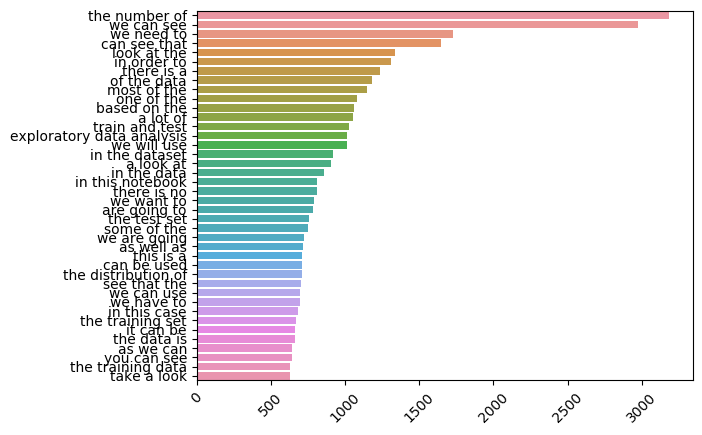

In [13]:
# show phrases counts
counts = pd.Series(top_starts).value_counts()
sns.barplot(y=counts[:40].index, x=counts[:40])
plt.xticks(rotation=45)
plt.show()

## skewness

In [14]:
# get distributions and skewness on most counted pharses
skewness = {}
distributions = {}
for v in tqdm(counts[counts > 200].index):  # todo maybe change to number of items. top 300 words smth like this?
    skewness[v] = skew(
        markdowns[markdowns['source'].str.contains(v)]['pct_rank'].values
    )
    distributions[v] = markdowns[markdowns['source'].str.contains(v)]['pct_rank'].values

In [48]:
# sort by top skewed phrases
top_skewed_keys = {
    k: v for k, v in reversed(sorted(skewness.items(), key=lambda item: abs(item[1])))
}

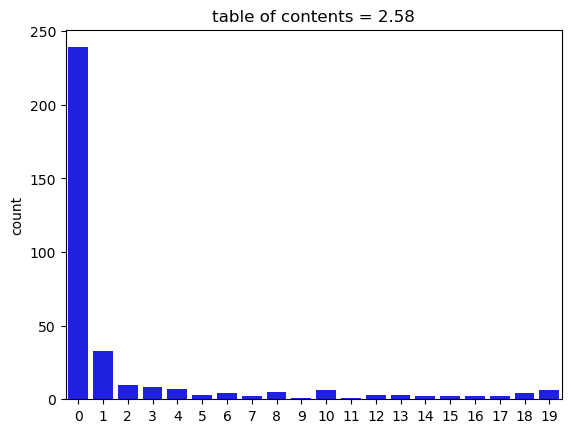

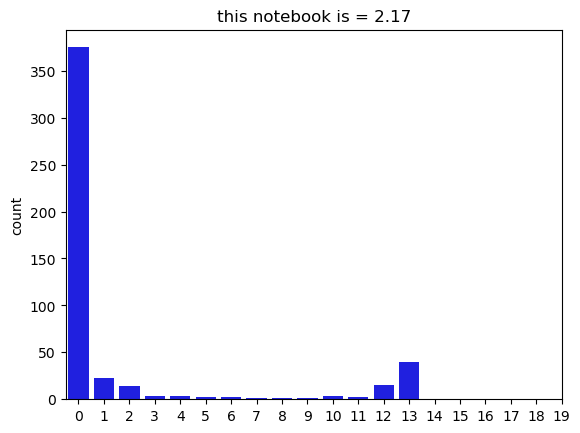

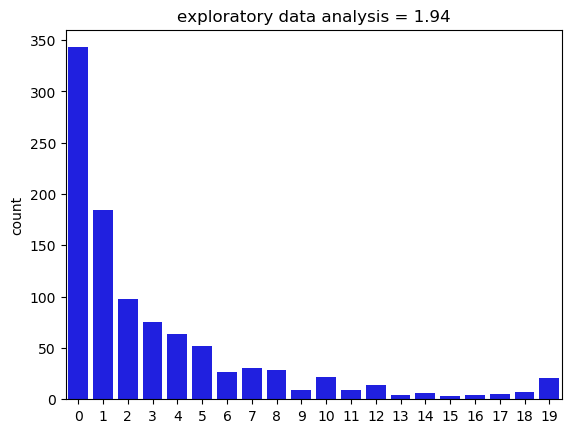

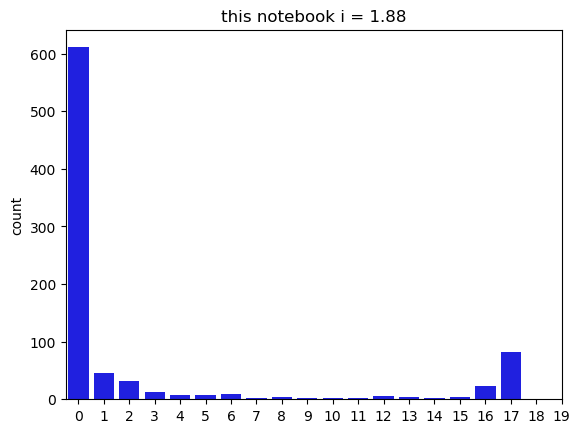

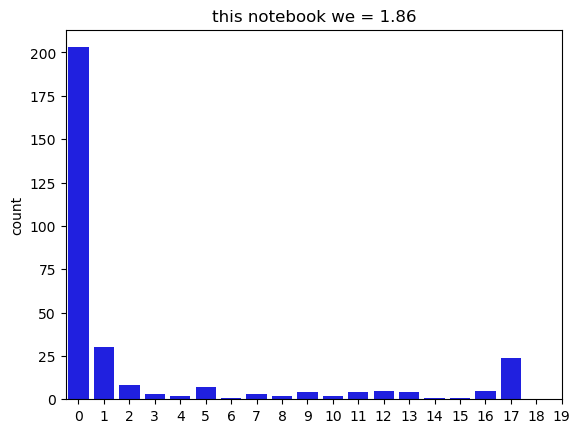

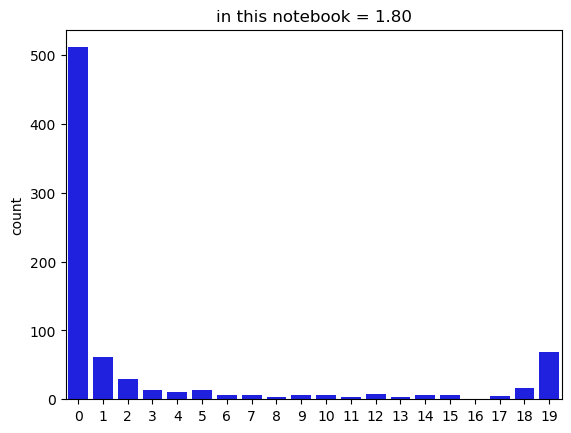

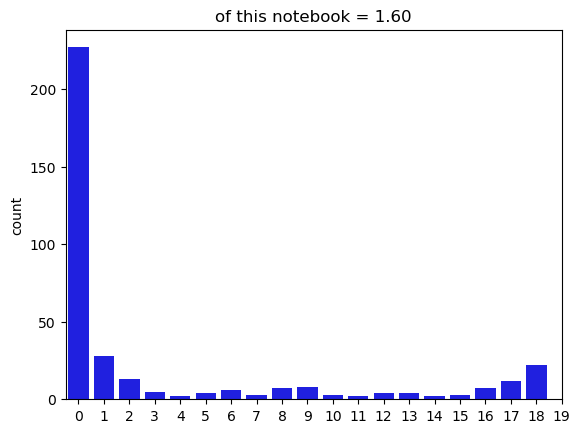

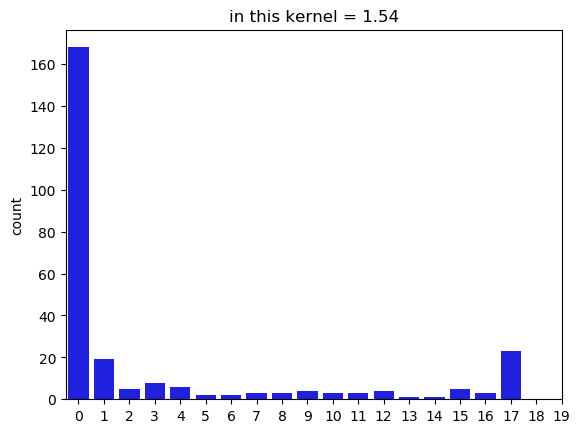

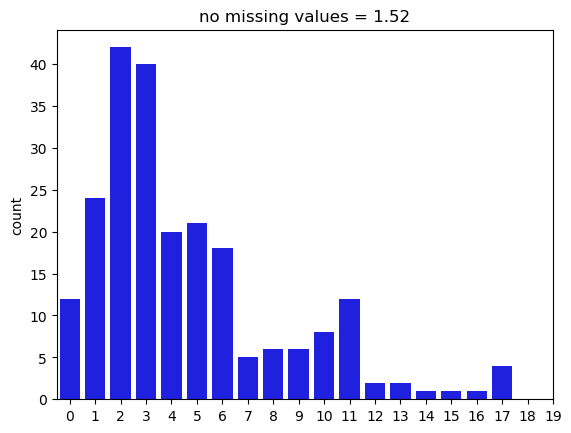

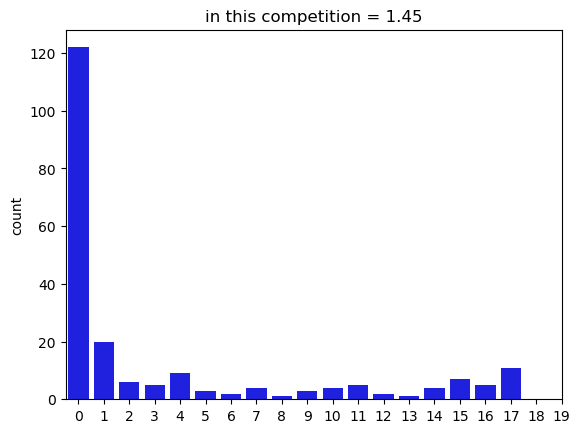

In [16]:
# split for bins and show their distributions
bins = np.array([x/100 for x in range(0, 100, 5)])

for key in list(top_skewed_keys.keys())[:10]:
    inds = np.digitize(distributions[key], bins)
    ax = sns.countplot(inds, color="blue")
    ax.set_title(f'{key} = {skewness[key]:.2f}')
    plt.xticks(np.arange(len(bins)))
    ax.set_xticklabels(np.arange(len(bins)))
    # ax.set_xlim(0, 1)
    plt.show()

In [4]:
find_model_phrases_skewness.__name__

'find_model_phrases_skewness'

In [2]:
def find_model_phrases_skewness(keywoards, markdowns, counts_threshold=10):
    counts = pd.Series(keywoards).value_counts()
    skewness = {}
    distributions = {}
    for v in tqdm(counts[counts > counts_threshold].index):
        skewness[v] = skew(
            markdowns[markdowns['source'].str.contains(v)]['pct_rank'].values
        )
        distributions[v] = markdowns[markdowns['source'].str.contains(v)]['pct_rank'].values
    top_skewed_keys = {
        k: v for k, v in reversed(sorted(skewness.items(), key=lambda item: abs(item[1])))
    }
    return top_skewed_keys, distributions, skewness

def plot_skewness(top_skewed_keys, distributions, skewness, number_of_plots=10):
    for key in list(top_skewed_keys.keys())[:number_of_plots]:
        inds = np.digitize(distributions[key], bins)
        ax = sns.countplot(inds, color="blue")
        ax.set_title(f'{key} = {skewness[key]:.2f}')
        plt.xticks(np.arange(len(bins)))
        ax.set_xticklabels(np.arange(len(bins)))
        plt.show()

## RIP KeyBert

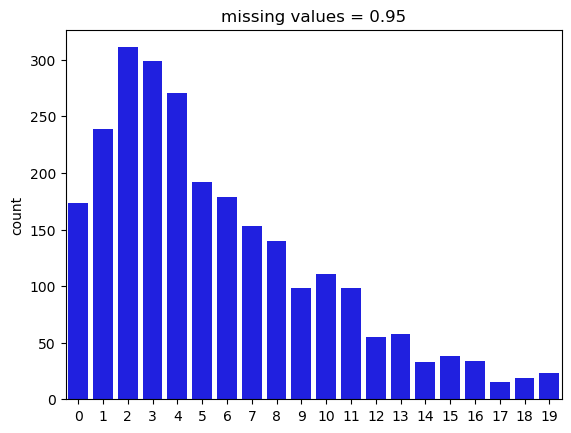

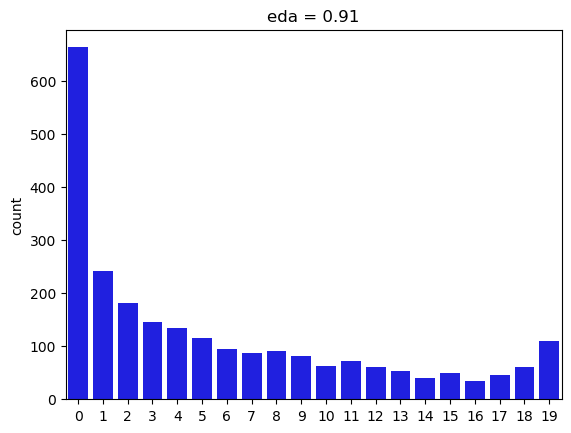

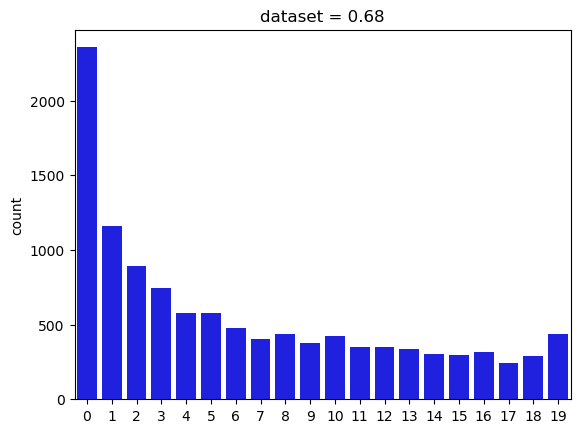

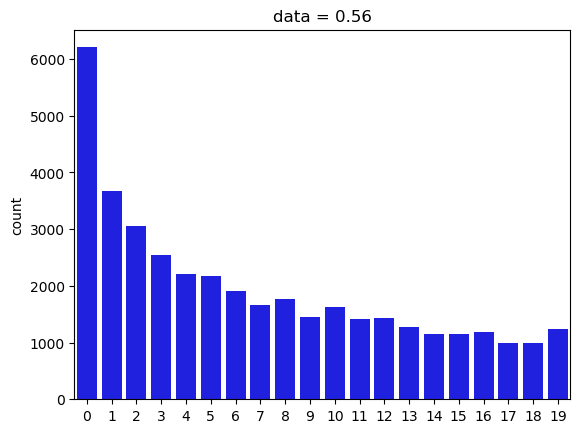

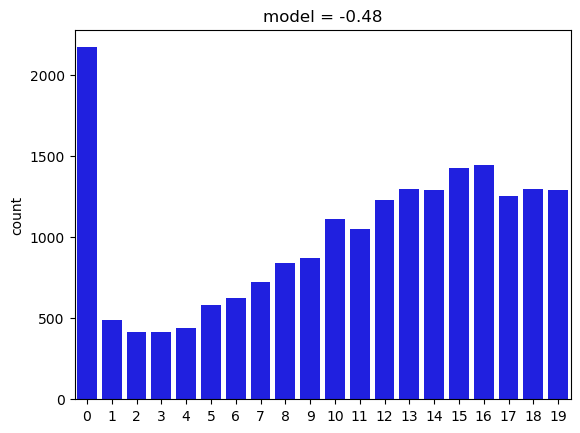

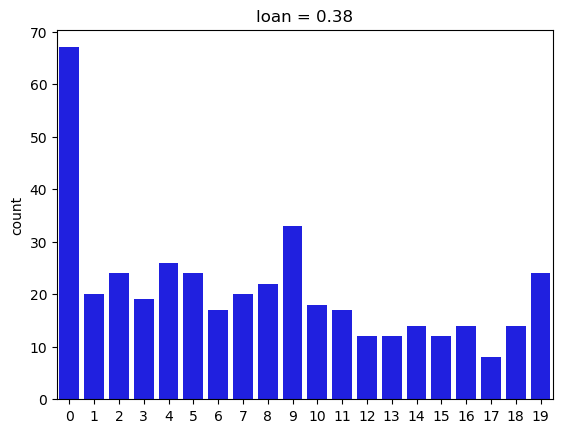

In [38]:
plot_skewness(*find_model_phrases_skewness(keywoards, markdowns))

## Go on

## Next step emoji

In [25]:
values = markdowns['source'].values

In [36]:
import emoji

In [ ]:
markdowns.apply(lambda x: text_preprocessing(x['source']), axis=1).values

In [43]:
for value in values:
    em = ' '.join(c for c in value if c in emoji.UNICODE_EMOJI['en'])
    if em:
        print(em)
        print(text_preprocessing(emoji.demojize(em)))
        break

🔮
crystalball


## image link regex

In [125]:
from nltk.corpus import wordnet

In [270]:
import regex
image_pattern = r'(!\[([^\]]*)\]\((.*?)\s*("(?:.*[^"])")?\s*\))'
def replace_image_with_label(text):
    print(text)
    matches = regex.findall(image_pattern, text)
    for match in matches:
        if match[1]:
            result = text_preprocessing(' '.join(match[1].split('.')[:-1]))
            result = "image link " + ' '.join(result.split("_"))
        else:
            result = "image link "
        text = text.replace(match[0], result)
    return text_preprocessing(text)

#Coronavirus Drugs—To Have and Have Not by Joelle Dountio O.
Africa's least developed countries should apply a WTO patent waiver, to import generic versions of future COVID-19 drugs

![](https://www.thinkglobalhealth.org/sites/default/files/2020-05/Joelle.Ofimboudem-CoV-Patents-4.30.20-RTX7EKXB-THREE-TWO.jpg)https://www.thinkglobalhealth.org/tag/guinea-bissau
coronavirus drugs to have and have not by joelle dountio o africa s least developed countries should apply a wto patent waiver to import generic versions of future covid number drugs image link link
------------------------------
![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTQXRC8iSNx0JbH7N0C_bA-bmOPqbJtVN1gG_3bi0536aQL9LEnM3_5eCRG0r8wOyxo0hMTP4NsQHrM00oac5MNIQ&usqp=CAU&ec=45687378)covid19gb.com
image link number com
------------------------------
![](http://blog.quikr.com/wp-content/uploads/2016/06/buy-second-hand-car-transfer-documents.jpg)
image link
------------------------------
# Topic Modelling with LDA

Anot
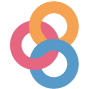
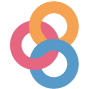
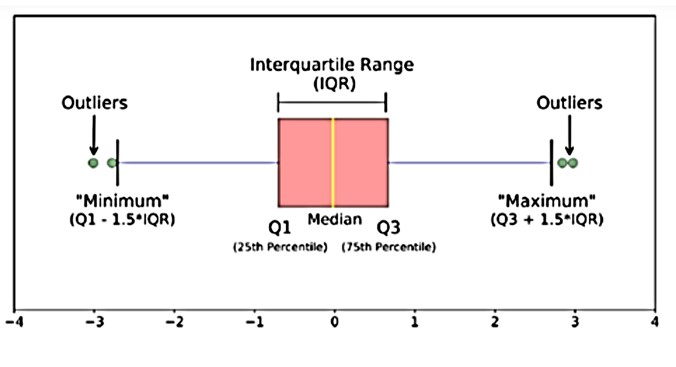
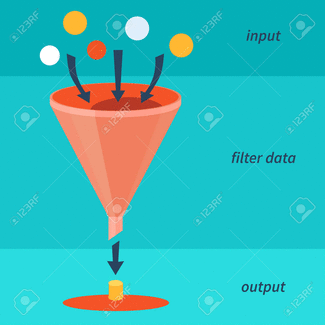
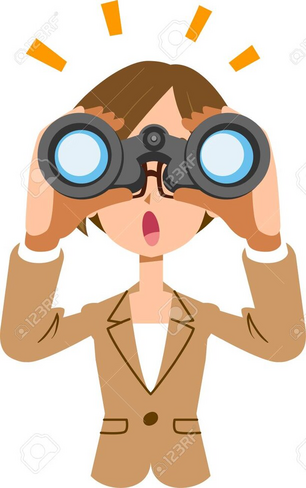
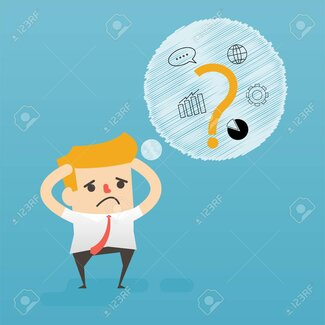
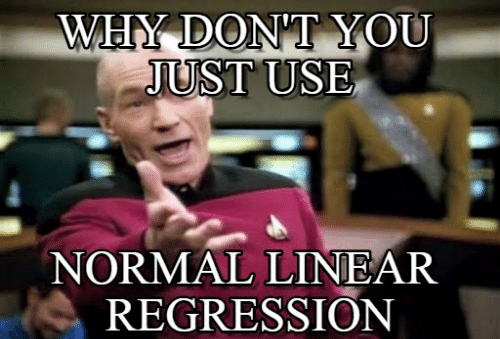
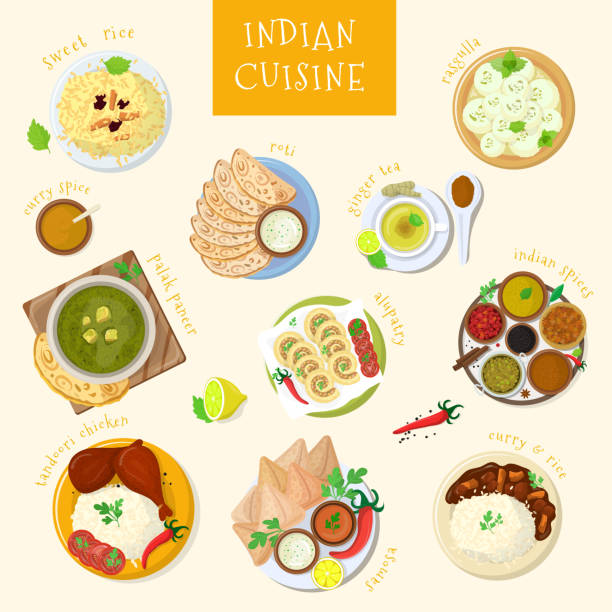
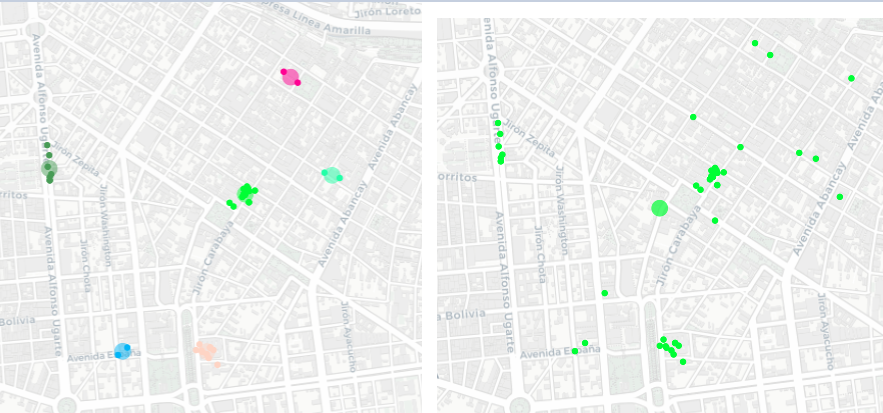
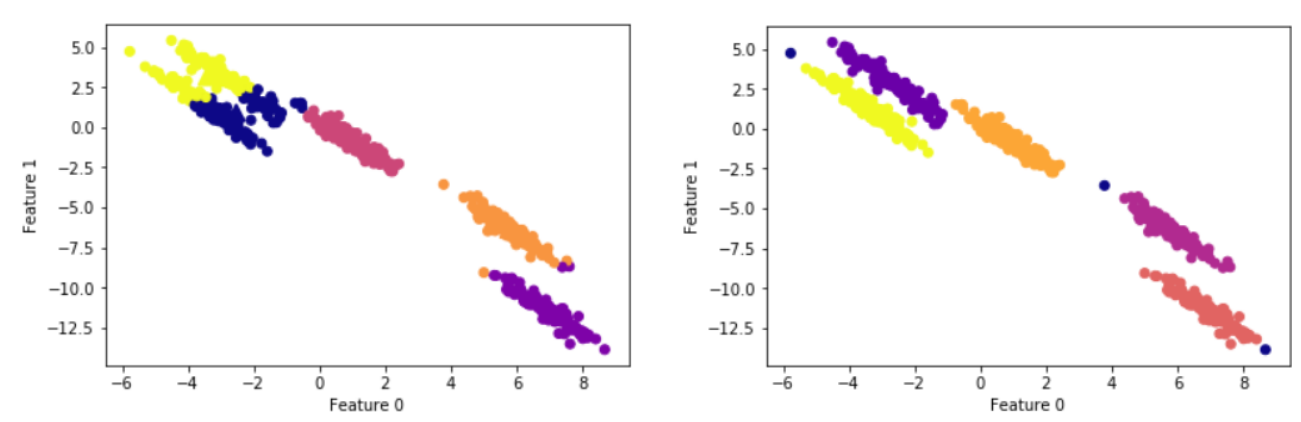
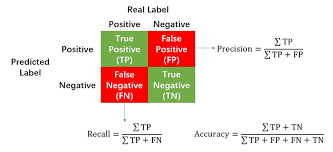
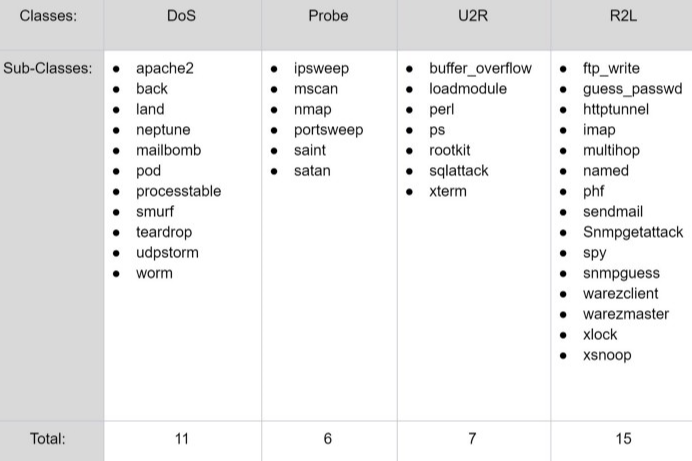
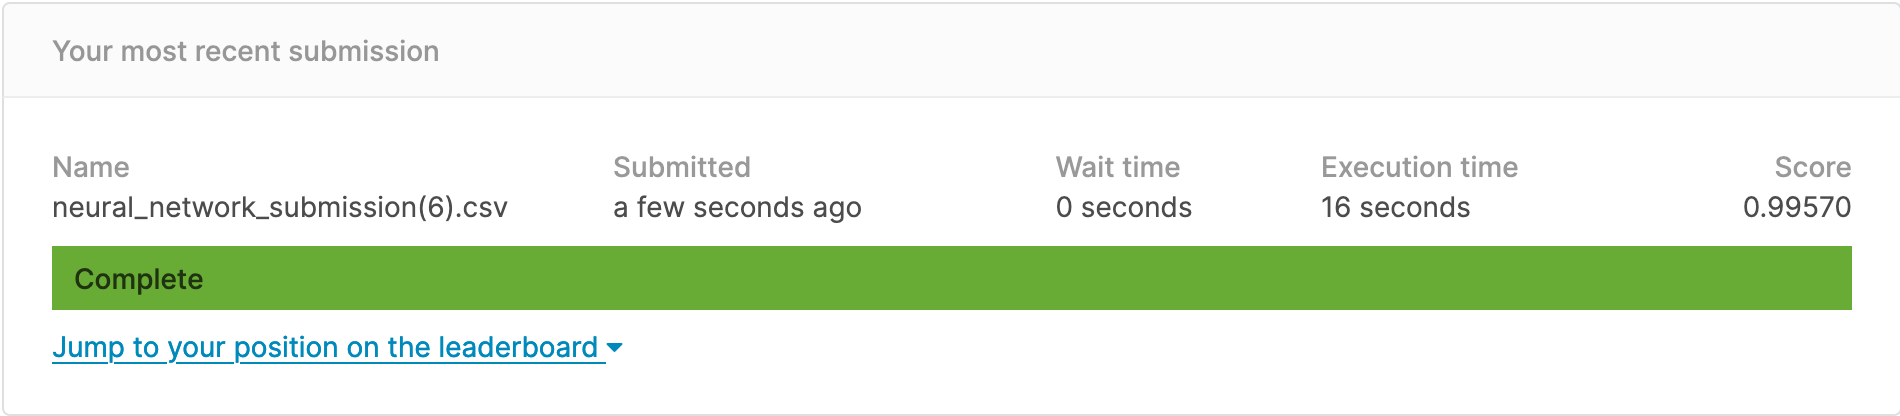
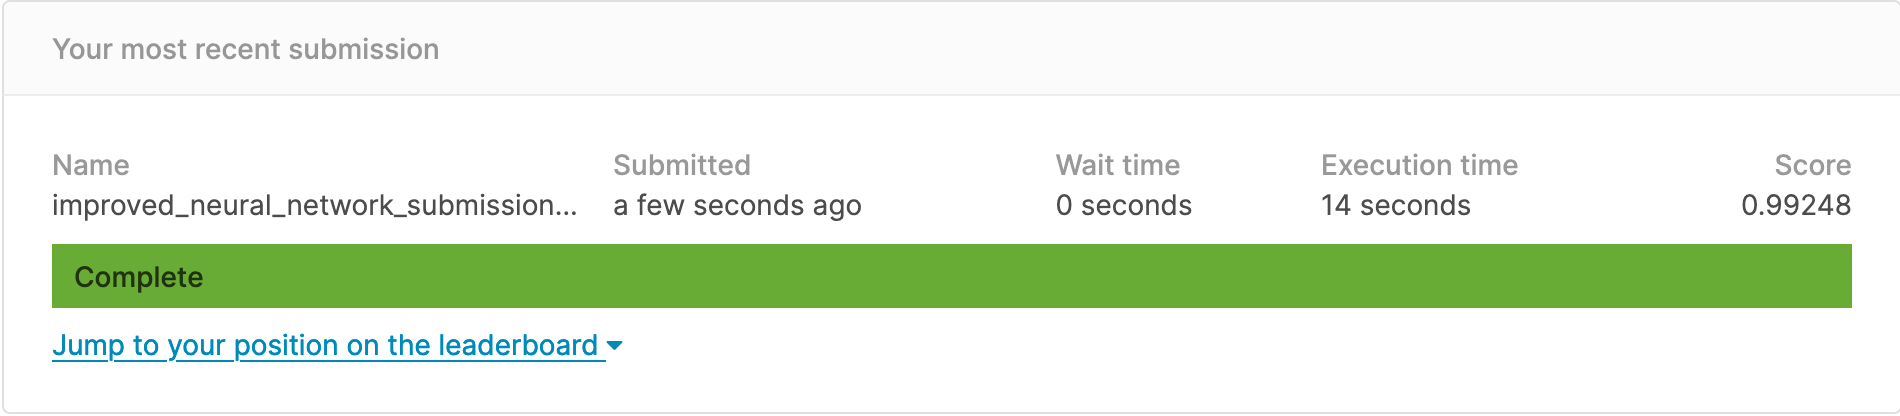
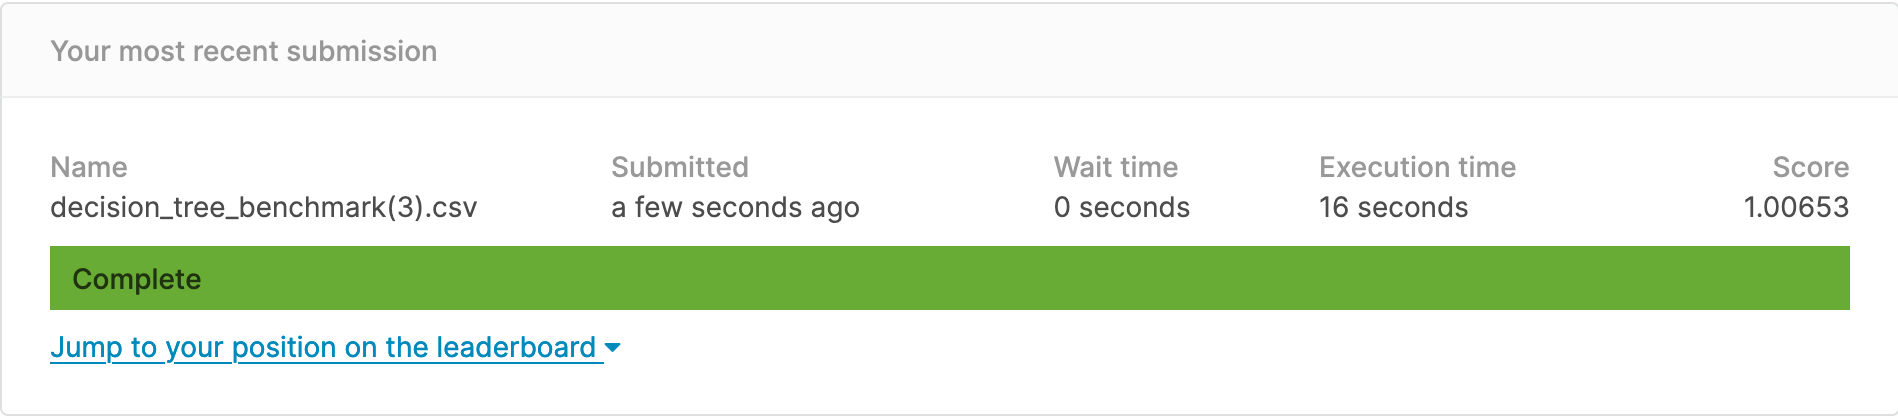
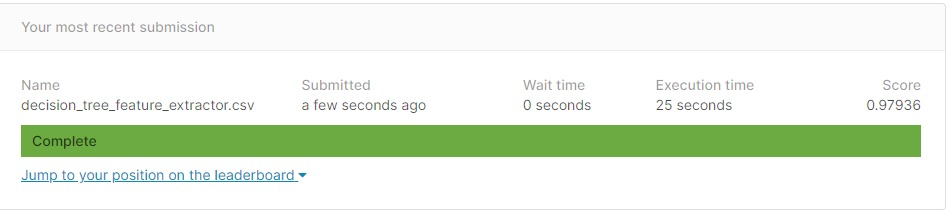
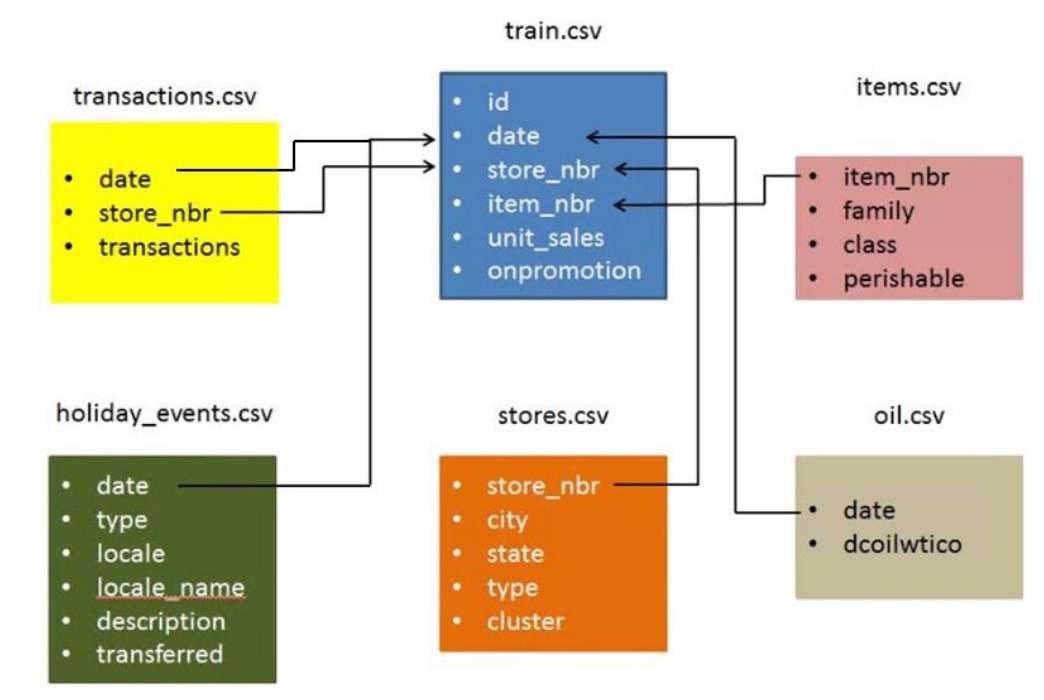

In [271]:
for value in values:
    if "![" in value:
        print(get_image_label(value))
        print("-"*30)

## heading

In [265]:
def get_hedding_order(text):
    text = text.strip()
    heading_number = text.split(" ")[0].count("#")
    if len(text.split(" ")[0]) != heading_number or not heading_number:
        return None
    return heading_number

# Bert uncased

In [11]:
!pip install transformers[torch]

  Using cached transformers-4.20.1-py3-none-any.whl (4.4 MB)
  Using cached huggingface_hub-0.8.1-py3-none-any.whl (101 kB)
  Using cached tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.6 MB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 20.1
    Uninstalling packaging-20.1:
      Successfully uninstalled packaging-20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.


In [12]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [13]:
md = markdowns[['source', 'pct_rank']]

In [14]:
encoded_corpus = tokenizer(text=md.source.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)

In [15]:
input_ids = encoded_corpus['input_ids']

In [16]:
attention_mask = encoded_corpus['attention_mask']

In [17]:
labels = md.pct_rank.to_numpy().astype("float32")

In [18]:
from sklearn.model_selection import train_test_split
test_size = 0.1
seed = 42
train_inputs, test_inputs, train_labels, test_labels = \
            train_test_split(input_ids, labels, test_size=test_size, 
                             random_state=seed)
train_masks, test_masks, _, _ = train_test_split(attention_mask, 
                                        labels, test_size=test_size, 
                                        random_state=seed)

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, 
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader
train_dataloader = create_dataloaders(train_inputs, train_masks, 
                                      train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks, 
                                     test_labels, batch_size)

In [28]:
a = model.camembert

In [31]:
import torch.nn as nn
from transformers import DistilBertModel
class CamembertRegressor(nn.Module):
    
    def __init__(self, drop_rate=0.2, freeze_camembert=False):
        
        super(CamembertRegressor, self).__init__()
        D_in, D_out = 768, 1
        
        self.camembert = \
                   DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out))
    def forward(self, input_ids, attention_masks):
        
        outputs = self.camembert(input_ids, attention_masks)
        class_label_output = outputs
        outputs = self.regressor(class_label_output)
        return outputs
model = CamembertRegressor(drop_rate=0.2)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
model.to(device)


No GPU available, using the CPU instead.


CamembertRegressor(
  (camembert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linea

In [33]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [34]:
from transformers import get_linear_schedule_with_warmup
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,       
                 num_warmup_steps=0, num_training_steps=total_steps)

In [35]:
loss_function = nn.MSELoss()


In [ ]:
from torch.nn.utils.clip_grad import clip_grad_norm
def train(model, optimizer, scheduler, loss_function, epochs,       
          train_dataloader, device, clip_value=2):
    for epoch in range(epochs):
        print(epoch)
        print("-----")
        best_loss = 1e10
        model.train()
        for step, batch in enumerate(train_dataloader): 
            print(step)  
            batch_inputs, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)           
            loss = loss_function(outputs.squeeze(), 
                             batch_labels.squeeze())
            loss.backward()
            clip_grad_norm(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
                
    return model
model = train(model, optimizer, scheduler, loss_function, epochs, 
              train_dataloader, device, clip_value=2)


0
-----
0


In [ ]:
def evaluate(model, loss_function, test_dataloader, device):
    model.eval()
    test_loss, test_r2 = [], []
    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = \
                                 tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        loss = loss_function(outputs, batch_labels)
        test_loss.append(loss.item())
        r2 = r2_score(outputs, batch_labels)
        test_r2.append(r2.item())
    return test_loss, test_r2
def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2
